# Logistic Regression

Logistic regression is another regression model used when a response variable is logical or binary (true/false, yes/no, etc.). Unlike linear regression, which predicts continuous numerical outcomes, logistic regression predicts a discrete categorical outcome with an assigned probability.

The dataset used for demonstration will be a sample telecommunications company customer churn dataset.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

churn = pd.read_csv('Data/churn.csv')
churn.head()

,has_churned,time_since_first_purchase,time_since_last_purchase
0,0,-1.089221,-0.721322
1,0,1.182983,3.634435
2,0,-0.846156,-0.427582
3,0,0.086942,-0.535672
4,0,-1.166642,-0.672640


From the data, note that:
- A `has_churned` value of 0 means that a customer is still an active subscriber; otherwise, it is 1.
- The time values for columns `time_since_first_purchase` and `time_since_last_purchase` are as they are due to standardization for privacy reasons.

First, let's see what happens if we try to fit the data with a linear regression model.

In [2]:
from statsmodels.formula.api import ols

churn_linear = ols('has_churned ~ time_since_last_purchase', data=churn).fit()
intercept, slope = churn_linear.params

# Coefficients will be visualized shortly
print(intercept, slope)

0.49078015222740057 0.06378347043715497


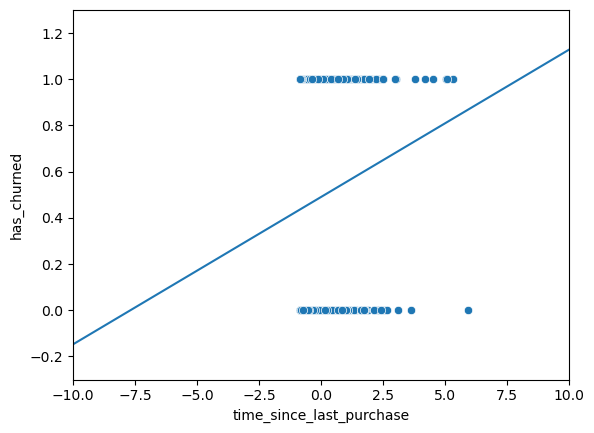

In [3]:
sns.scatterplot(
    x='time_since_last_purchase',
    y='has_churned',
    data=churn
)

plt.axline(xy1=(0, intercept), slope=slope)

plt.xlim(-10,10)
plt.ylim(-0.3, 1.3)
plt.show()

Notice how the model predicts probabilities greater than 1 and less than zero. This shows that linear regression is not the ideal model for the data.

In [4]:
# Importing the logistic regression model 
from statsmodels.formula.api import logit

# Notice the logit() method call here is similar to
# the ols() method call we do in linear regression

churn_logit = logit('has_churned ~ time_since_last_purchase', data=churn).fit()
churn_logit.params

Optimization terminated successfully.
         Current function value: 0.683000
         Iterations 4


Intercept                  -0.035019
time_since_last_purchase    0.269215
dtype: float64

The parameters returned here are slightly different. The first parameter, intercept or `b_0` (beta 0), represents the baseline log-odds when *X = 0*(predictor variable is *X*). The slope (here, it is `time_since_last_purchase`), or `b_1` (beta 1), shows the change in log-odds per 1-unit increase in *X*.

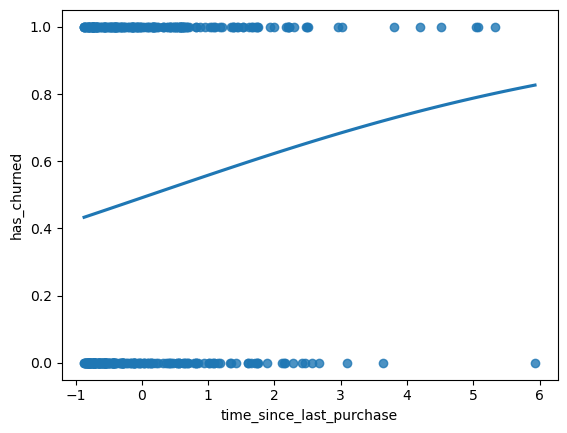

In [5]:
# Visualizing the model
# Notice that the curve is not a straight line; it's more of an S-curve
# Well, it will look more of an S-curve on data with greater range

sns.regplot(
    x='time_since_last_purchase',
    y='has_churned',
    data=churn,
    ci=None,
    logistic=True
)

plt.show()


### Predictions, Odd Ratios, and Different Methods of Scaling the Responses
Making predictions with a logistic regression in statsmodels is very similar to how we do it with linear regression models.


##### Plotting Using Probabilities

In [6]:
# Plotting methods implemented as new methods
# to reduce repetitive manual plotting
def regplot_churn(df):
    sns.regplot(
    x='time_since_last_purchase',
    y='has_churned',
    data=df,
    ci=None,
    logistic=True
    )

def scatter_churn(df, response : str):
    sns.scatterplot(
        x='time_since_last_purchase',
        y=response,
        data=df,
        color='red'
    )

In [7]:
# Sample independent variables for prediction
exp_data = pd.DataFrame(
    {'time_since_last_purchase':np.arange(-1, 6.25, 0.25)}
)

predict_data = exp_data.assign(
    has_churned=churn_logit.predict(exp_data)
)

predict_data.head()

,time_since_last_purchase,has_churned
0,-1.00,0.424523
1,-0.75,0.441043
2,-0.50,0.457695
3,-0.25,0.474441
4,0.00,0.491246


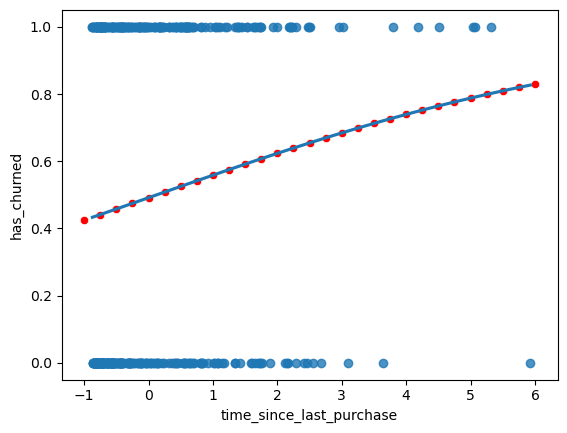

In [8]:
regplot_churn(churn)

scatter_churn(predict_data, 'has_churned')

plt.show()

##### Plotting using Most Likely Outcome
Instead of dealing with raw probabilities, the predictions can be plotted according to the most likely outcome which can be done by simply rounding the probabilities. A predicted churn chance of 0.5 or greater means a customer will churn, while anything less than 0.5 means that they won't.

Using this method, values and changes are easier to interpret at the cost of preciseness.

In [9]:
# Rounded probabilities
predict_data['most_likely_outcome'] = np.round(predict_data['has_churned'])
predict_data.head()

,time_since_last_purchase,has_churned,most_likely_outcome
0,-1.00,0.424523,0.0
1,-0.75,0.441043,0.0
2,-0.50,0.457695,0.0
3,-0.25,0.474441,0.0
4,0.00,0.491246,0.0


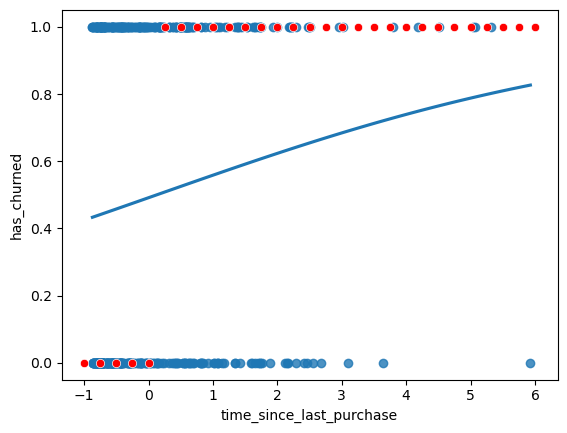

In [10]:
regplot_churn(churn)

scatter_churn(predict_data, 'most_likely_outcome')

plt.show()

# Plot now shows rounded predictions

##### Plotting Using Odds Ratios
An odds ratio is defined as the probability of an event occurring divided by the probability that it does not. Say we have a probability *p*, then the odds ratio is *p / (1-p)*. Representing predictions in this way is much more precise but changes can be tricky to interpret.

In [11]:
# Creating a column representing odds ratio
predict_data['odds_ratio'] = (predict_data['has_churned'] / (1 - predict_data['has_churned']))
predict_data.head()

,time_since_last_purchase,has_churned,most_likely_outcome,odds_ratio
0,-1.00,0.424523,0.0,0.737688
1,-0.75,0.441043,0.0,0.789046
2,-0.50,0.457695,0.0,0.843980
3,-0.25,0.474441,0.0,0.902738
4,0.00,0.491246,0.0,0.965587


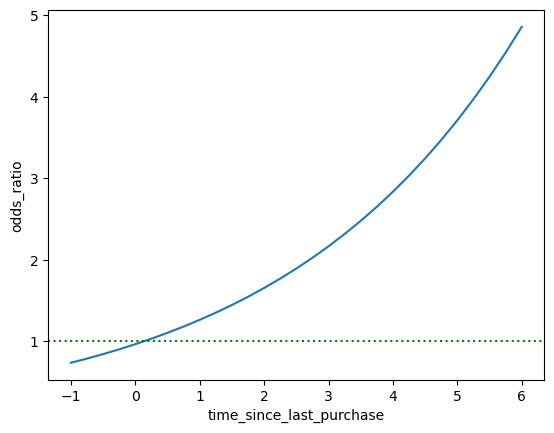

In [12]:
# We would need to visualize the odds ratio using a line plot 
# since using a logistic regplot wouldnt make sense
sns.lineplot(
    x='time_since_last_purchase',
    y='odds_ratio',
    data=predict_data
)

# axhline() plots a horizontal line across the entire
# plot or a defined interval
plt.axhline(y=1, linestyle='dotted', color='green')

plt.show()

The green dotted line at *y = 1* shows the point at which the chance of churning is as likely as the chance of not churning. Also, notice that the lower left portion of the curve shows the chance of churning is less than the chance of not churning (denoted by the probabilities less than 1), and the upper right portion of the curve shows thhe chance of churning being greater than the chance of not churning.

##### Plotting Using Log Odd Ratios
An interesting characteristic of the odd ratios is that they behave linearly when converted into logarithmic scale. Logarithmic scale odd ratios are precise and changes can be intuitively interpreted, but the raw values may be confusing. 


It's as simple as applying a y-scale transformation:

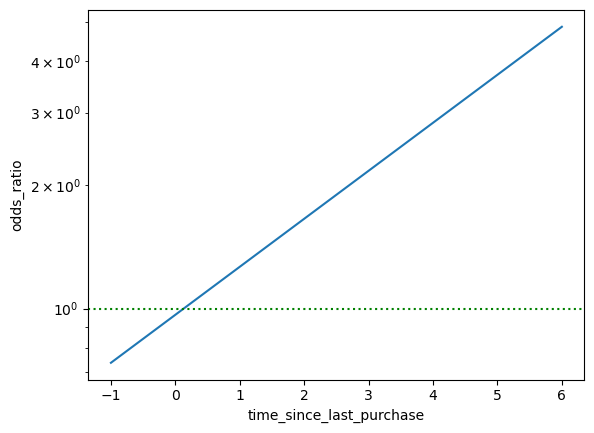

In [13]:
sns.lineplot(
    x='time_since_last_purchase',
    y='odds_ratio',
    data=predict_data
)

plt.axhline(y=1, linestyle='dotted', color='green')
plt.yscale('log')
plt.show()

The actual logg odd ratio values can be calculated like this should you need them.

In [14]:
predict_data['log_odd_ratio'] = np.log(predict_data['odds_ratio'])
predict_data.head()

,time_since_last_purchase,has_churned,most_likely_outcome,odds_ratio,log_odd_ratio
0,-1.00,0.424523,0.0,0.737688,-0.304234
1,-0.75,0.441043,0.0,0.789046,-0.236931
2,-0.50,0.457695,0.0,0.843980,-0.169627
3,-0.25,0.474441,0.0,0.902738,-0.102323
4,0.00,0.491246,0.0,0.965587,-0.035019


### Quantifying Logistic Regression Fit 

Unlike the diagnostic plots used for linear models, such plots are less useful for analyzing logistic regression models. Instead of using plots, we use **confusion matrices**.

When dealing with logical response variables, there are four possible outcomes: 
- Actual True (AT)
- Predicted True (PT)
- Actual False (AF)
- Predicted False (PF)




*The above outcomes are originally arranged in a table/matrix form. Consider looking it up to get a clearer understanding of what it looks like.*




A model that predicts true (PT) but the data says otherwise (AF), the result is a **false positive**. Likewise, if the model predicts false (PF) when the data is actually true, the result is called a **false negative**. These are the two types of bad cases.

In [ ]:
# Get the actual responses and the rounded prediction probabilities
actual_response = churn['has_churned']
predict_response = np.round(churn_logit.predict())

In [ ]:
# Create a dataframe with the two series above
outcomes = pd.DataFrame({
    'response_actual':actual_response,
    'response_predict':predict_response
})

outcomes.head()

,response_actual,response_predict
0,0,0.0
1,0,1.0
2,0,0.0
3,0,0.0
4,0,0.0


In [ ]:
# Call value_counts() to get the count of each combination of responses
outcomes.value_counts(sort=False)

# Alternatively, the confusion matrix can be made as an array like this
# conf_matrix = churn_logit.pred_table()

response_actual  response_predict
0                0.0                 141
                 1.0                  59
1                0.0                 111
                 1.0                  89
Name: count, dtype: int64

In [ ]:
# The mosaic plot from statsmodels can also be used to 
# visualize the confusion matrix
from statsmodels.graphics.mosaicplot import mosaic


The above output shows a confusion matrix. Notice that we correctly predicted that 141 customers did not actually churn while getting 59 of such predictions wrong (false positives). We also made 89 correct predictions of customers churning but we have 111 false negative predictions.